In [20]:
#this allows plots to be displayed inline with the notebook
%matplotlib inline 

Generally, you want to put your import statements at the top of the code, whether in notebooks or code files.

These first two import statements bring in the matplotlib plotting library and the numpy library, two core components of the "Scipy Stack", using a common convention among scientific Python developers (numpy as np, pyplot as plt).

In [21]:
import matplotlib.pyplot as plt
import numpy as np

These import statements bring in the PAGER models (population growth, exposure, fatality, etc.)

In [22]:
from losspager.models.emploss import LognormalModel,EmpiricalLoss
from losspager.models.growth import PopulationGrowth
from losspager.models.exposure import Exposure
from losspager.models.econexposure import EconExposure

These imports bring in other useful modules in the Python standard library, and other oddments.

In [23]:
import os.path
import time

from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona

LognormalModel objects contain properties and methods for the lognormal fatality models.  This object contains a number of methods to calculate losses (fatalities and economic losses), calculate the loss rates for given MMI values, and even override the lognormal model with arbitrary rates.

To construct a LognormalModel, you provide it with a name (usually two letter country code) theta, beta, L2G, and (for economic losses) alpha values.  Here we're ignoring the L2G values and simply assigning zero, as these are not used in loss calculations.

Fatalities
----------

In [24]:
iran = LognormalModel('IR',9.318099,0.100001,0.0)
california = LognormalModel('XF',37.729406,0.360337,0.0)
afghanistan = LognormalModel('AF',11.613073,0.180683,0.0)
china = LognormalModel('CN',10.328811,0.100058,0.0)
japan = LognormalModel('JP',11.862534,0.100779,0.0)

A lognormal fatality model "knows" how deadly it is (by calculating the area under the curve defined by MMI values from 5-9 and the fatality rates.)  This allows the user to compare two models to each other, and even sort a list of them.

In [25]:
print('Iran is more deadly than California: %s\n' % (iran > california))
mlist = [iran,california,afghanistan,china,japan]
mlist.sort()
print('Sorted list of country models:')
print('%5s %6s %6s %-6s %14s' % ('Name','Theta','Beta','Area','Deaths'))
for model in mlist:
    exp_pop = np.array([1e6,1e6,1e6,1e6,1e6])
    mmirange = np.arange(5,10)
    deaths = model.getLosses(exp_pop,mmirange)
    print('%5s %6.3f %6.3f %6.4f %14.4f' % (model.name,model.theta,model.beta,model.getArea(),deaths))

Iran is more deadly than California: True

Sorted list of country models:
 Name  Theta   Beta Area           Deaths
   XF 37.729  0.360 0.0000        44.8561
   JP 11.863  0.101 0.0016      3115.9749
   CN 10.329  0.100 0.0476     89743.3535
   AF 11.613  0.181 0.0618    101396.0790
   IR  9.318  0.100 0.2478    429899.6846


You can plot the fatality rates of each of these models:

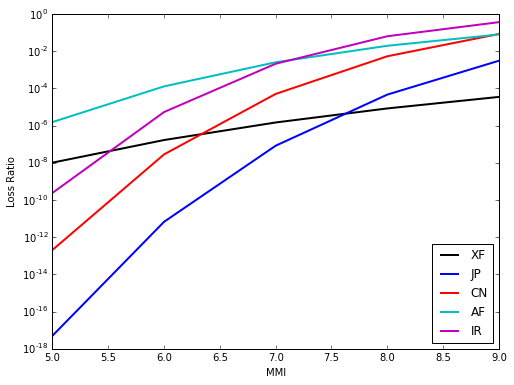

In [26]:
mmirange = np.arange(5,10)
f = plt.figure(figsize=(8,6))
colors = ['k','b','r','c','m']
for i in range(0,len(mlist)):
    rates = mlist[i].getLossRates(mmirange)
    plt.semilogy(mmirange,rates,colors[i],lw=2);

names = [m.name for m in mlist]
plt.legend(names,loc='lower right',numpoints=2);
plt.xlabel('MMI');
plt.ylabel('Loss Ratio');

You can see the fatality rates as rates by simply printing the LognormalModel object:

In [27]:
print('California Model:\n%s' % california)
print('Afhanistan Model:\n%s' % japan)

California Model:
MMI 5: 1 in 98,078,525
MMI 6: 1 in 5,971,984
MMI 7: 1 in 679,957
MMI 8: 1 in 119,392
MMI 9: 1 in 28,709

Afhanistan Model:
MMI 5: 1 in 197,832,863,534,103,808
MMI 6: 1 in 148,550,137,280
MMI 7: 1 in 12,055,318
MMI 8: 1 in 21,578
MMI 9: 1 in 325



You can obtain the name, theta/beta/L2G values as properties from the LognormalModel object:

In [28]:
print('California:')
print('\tName %s' % california.name)
print('\tTheta %f' % california.theta)
print('\tBeta %f' % california.beta)
print('\tL2G %f' % california.l2g)

California:
	Name XF
	Theta 37.729406
	Beta 0.360337
	L2G 0.000000


Up to this point, we've defined each model manually.  We have all of these models for PAGER in one XML data file, which is included in this code repository. The EmpiricalLoss() class exists to handle large numbers of LognormalModel() objects, and has a method loadFromXML() to read in the XML file and create an EmpiricalLoss() instance.

In [29]:
xmlfile = os.path.join(os.getcwd(),'..','test','data','fatality.xml')
empfat = EmpiricalLoss.loadFromXML(xmlfile)

You can retrieve LognormalModel() objects from EmpiricalFatality() objects using the getModel() method.

In [30]:
chile = empfat.getModel('CL')
chile

MMI 5: 1 in 17,293,177
MMI 6: 1 in 468,260
MMI 7: 1 in 32,082
MMI 8: 1 in 4,129
MMI 9: 1 in 832

And this is what PAGER will do... 

(Example: Northridge)

In [32]:
t1 = time.time()
growthfile = os.path.join(os.getcwd(),'..','test','data','WPP2015_POP_F02_POPULATION_GROWTH_RATE.xls')
popgrowth = PopulationGrowth.loadFromUNSpreadsheet(growthfile)
sampledir = os.path.join(os.getcwd(),'..','test','data','eventdata','northridge')
popfile = os.path.join(sampledir,'northridge_gpw.flt')
isofile = os.path.join(sampledir,'northridge_isogrid.bil')
shakefile = os.path.join(sampledir,'northridge_grid.xml')
expmodel = Exposure(popfile,2012,isofile,popgrowth)
expdict = expmodel.calcExposure(shakefile)
for key,exp_pop in expdict.items():
    print('Exposure for %s' % key)
    for i in range(0,len(exp_pop)):
        mmi = i+1
        print('\tMMI %i: %s' % (mmi,format(int(exp_pop[i]),',d')))
        
#call fatality model
fat_results = empfat.getLosses(expdict)
for key,value in fat_results.items():
    print('\nFatalities for %s: %i' % (key,value))
t2 = time.time()
print('\nTotal elapsed time for loss calculations: %.2f seconds' % (t2-t1))

Exposure for TotalExposure
	MMI 1: 0
	MMI 2: 0
	MMI 3: 1,817
	MMI 4: 1,767,260
	MMI 5: 5,840,985
	MMI 6: 5,780,298
	MMI 7: 2,738,374
	MMI 8: 1,559,657
	MMI 9: 4,094
	MMI 10: 0
Exposure for XF
	MMI 1: 0
	MMI 2: 0
	MMI 3: 1,817
	MMI 4: 1,767,260
	MMI 5: 5,840,985
	MMI 6: 5,780,298
	MMI 7: 2,738,374
	MMI 8: 1,559,657
	MMI 9: 4,094
	MMI 10: 0

Fatalities for TotalFatalities: 18

Fatalities for XF: 18

Total elapsed time for loss calculations: 1.45 seconds


In addition, the fatality module provides the ability to make a gridded fatality map.  Note that this map may not be a reliable way to determine the distribution of fatalities, particularly as you zoom in.

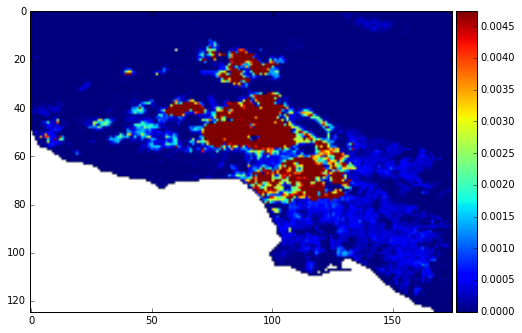

In [33]:
mmidata = expmodel.getShakeGrid().getLayer('mmi').getData()
popdata = expmodel.getPopulationGrid().getData()
isodata = expmodel.getCountryGrid().getData()
fatgrid = empfat.getLossGrid(mmidata,popdata,isodata)
f = plt.figure(figsize=(8,8))
dmin = np.nanmin(fatgrid)
dmax = np.nanmax(fatgrid)
dmean = np.nanmean(fatgrid)
dstd = np.nanstd(fatgrid)
#Here we're zooming in on the affected regions...
plt.imshow(fatgrid[125:250,125:300],vmin=dmin,vmax=dmean+(3*dstd));
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax);


We can also split up the fatalities from the above grid into input polygons.  Here we take a shapefile of Los Angeles County city boundaries, and use it to divide up the fatalities.

In [34]:
shapefile = os.path.join(sampledir,'City_BoundariesWGS84','City_Boundaries.shp')
popdict = expmodel.getPopulationGrid().getGeoDict()
shapes = []
f = fiona.open(shapefile,'r')
for row in f:
    shapes.append(row)
f.close()
fatshapes,totfat = empfat.getLossByShapes(mmidata,popdata,isodata,shapes,popdict)
for shape in fatshapes:
    if shape['properties']['fatalities'] > 0:
        cname = shape['properties']['CITY_NAME']
        deaths = shape['properties']['fatalities']
        print('%s: %i fatalities' % (cname,deaths))

Los Angeles: 12 fatalities
Santa Clarita: 1 fatalities


With all the fatality models at our disposal, it's easy to see what fatalities Northridge exposures would bring in other countries: 

In [35]:
for name in names:
    fmodel = empfat.getModel(name)
    exp_pop = expdict['XF'][4:9]
    exp_pop[-1] += expdict['XF'][-1] #MMI 10 is folded into MMI 9 for loss modeling
    deaths = fmodel.getLosses(exp_pop,np.arange(5,10))
    dstr = format(int(deaths),",d")
    print('%s fatalities from Northridge exposure: %8s' % (name,dstr))

XF fatalities from Northridge exposure:       18
JP fatalities from Northridge exposure:       85
CN fatalities from Northridge exposure:    8,801
AF fatalities from Northridge exposure:   38,562
IR fatalities from Northridge exposure:  106,524


We can also manually override the rates for a model with a custom rates array, which need not be lognormal in form.  Here we are verifying that doubling the default rates doubles the fatalities.

In [36]:
#Testing modifying rates and stuffing them back in...
chile = LognormalModel('CL',19.786773,0.259531,0.0)
rates = chile.getLossRates(np.arange(5,10))
modrates = rates * 2 #does this make event twice as deadly?

#roughly the exposures from 2015-9-16 CL event
expo_pop = np.array([0,0,0,1047000,7314000,1789000,699000,158000,0,0])
mmirange = np.arange(5,10)
chile_deaths = chile.getLosses(expo_pop[4:9],mmirange)
chile_double_deaths = chile.getLosses(expo_pop[4:9],mmirange,rates=modrates)
print('Chile model fatalities: %f' % chile_deaths)
print('Chile model x2 fatalities: %f' % chile_double_deaths)

Chile model fatalities: 64.295116
Chile model x2 fatalities: 128.590232


Economic Losses
---------------

All of the above fatality methods apply in a very similar way to economic losses.  The difference between calculating fatalities and dollars lost is by use of a subclass of the Exposure() class, EconExposure().

In [37]:
iran = LognormalModel('IR',9.483180,0.100000,7.949160,alpha=15.614500)
california = LognormalModel('XF',9.592240,0.100117,9.753500,alpha=14.433700)
afghanistan = LognormalModel('AF',9.013810,0.100000,4.113200,alpha=15.065400)
china = LognormalModel('CN',7.511120,0.100328,9.340890,alpha=9.794960)
japan = LognormalModel('JP',10.290800,0.100015,10.068600,alpha=13.389900)

Again, we can sort the country models by vulnerability.

In [38]:
mlist = [iran,california,afghanistan,china,japan]
mlist.sort()
print('Sorted list of country models:')
print('%5s %6s %6s %-6s %14s' % ('Name','Theta','Beta','Area','Dollars'))
for model in mlist:
    exp_pop = np.array([1e6,1e6,1e6,1e6,1e6])
    mmirange = np.arange(5,10)
    deaths = model.getLosses(exp_pop,mmirange)
    print('%5s %6.3f %6.3f %6.4f %14.4f' % (model.name,model.theta,model.beta,model.getArea(),deaths))

Sorted list of country models:
 Name  Theta   Beta Area          Dollars
   JP 10.291  0.100 0.0510     96077.9922
   XF  9.592  0.100 0.1668    297949.9017
   IR  9.483  0.100 0.1959    346196.7571
   AF  9.014  0.100 0.3691    616037.5872
   CN  7.511  0.100 1.4711   1953238.2380


Again, we can plot the loss rates for each of these countries against each other.

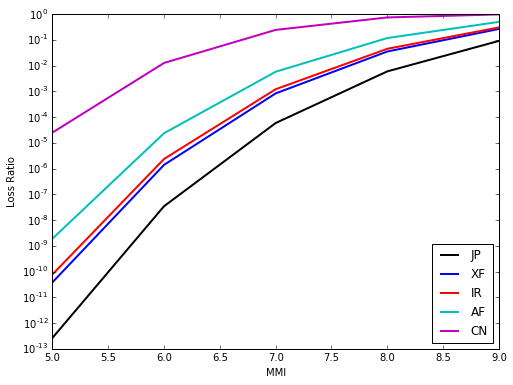

In [39]:
mmirange = np.arange(5,10)
f = plt.figure(figsize=(8,6))
colors = ['k','b','r','c','m']
for i in range(0,len(mlist)):
    rates = mlist[i].getLossRates(mmirange)
    plt.semilogy(mmirange,rates,colors[i],lw=2);

names = [m.name for m in mlist]
plt.legend(names,loc='lower right',numpoints=2);
plt.xlabel('MMI');
plt.ylabel('Loss Ratio');

Print the properties of the California economic loss model (now includes alpha).

In [40]:
print('California:')
print('\tName %s' % california.name)
print('\tTheta %f' % california.theta)
print('\tBeta %f' % california.beta)
print('\tAlpha %f' % california.alpha)
print('\tL2G %f' % california.l2g)

California:
	Name XF
	Theta 9.592240
	Beta 0.100117
	Alpha 14.433700
	L2G 9.753500


We can provide an XML file with economic models defined in it - the format is very similar to the fatality XML file. 

In [41]:
xmlfile = os.path.join(os.getcwd(),'..','test','data','economy.xml')
empeco = EmpiricalLoss.loadFromXML(xmlfile)

We can print out the rates of an economic model as well - recall that these rates include GDP and alpha, an exposure correction factor.

In [42]:
chile = empeco.getModel('CL')
chile

MMI 5: 1 in 73,844,840,115
MMI 6: 1 in 1,527,999
MMI 7: 1 in 2,045
MMI 8: 1 in 40
MMI 9: 1 in 4

And again, here is how PAGER would calculate dollar losses:

In [44]:
t1 = time.time()
growthfile = os.path.join(os.getcwd(),'..','test','data','WPP2015_POP_F02_POPULATION_GROWTH_RATE.xls')
popgrowth = PopulationGrowth.loadFromUNSpreadsheet(growthfile)
sampledir = os.path.join(os.getcwd(),'..','test','data','eventdata','northridge')
popfile = os.path.join(sampledir,'northridge_gpw.flt')
isofile = os.path.join(sampledir,'northridge_isogrid.bil')
gdpfile = os.path.join(os.getcwd(),'..','test','data','API_NY.GDP.PCAP.CD_DS2_en_excel_v2.xls')
xmlfile = os.path.join(os.getcwd(),'..','test','data','economy.xml')
shakefile = os.path.join(sampledir,'northridge_grid.xml')
expmodel = EconExposure(popfile,2012,isofile,popgrowth,gdpfile,xmlfile)
expdict = expmodel.calcExposure(shakefile)
for key,exp_pop in expdict.items():
    print('Economic Exposure for %s' % key)
    for i in range(0,len(exp_pop)):
        mmi = i+1
        print('\tMMI %i: %s' % (mmi,format(int(exp_pop[i]),',d')))
        
#call fatality model
eco_results = empeco.getLosses(expdict)
for key,value in eco_results.items():
    print('\nEconomic losses for %s: $%s' % (key,format(value,",d")))
t2 = time.time()
print('\nTotal elapsed time for loss calculations: %.2f seconds' % (t2-t1))

Economic Exposure for TotalEconomicExposure
	MMI 1: 0
	MMI 2: 0
	MMI 3: 728,470,957
	MMI 4: 708,529,215,105
	MMI 5: 2,341,765,511,296
	MMI 6: 2,317,434,902,061
	MMI 7: 1,097,867,875,064
	MMI 8: 625,297,098,357
	MMI 9: 1,641,364,941
	MMI 10: 0
Economic Exposure for XF
	MMI 1: 0
	MMI 2: 0
	MMI 3: 728,470,957
	MMI 4: 708,529,215,105
	MMI 5: 2,341,765,511,296
	MMI 6: 2,317,434,902,061
	MMI 7: 1,097,867,875,064
	MMI 8: 625,297,098,357
	MMI 9: 1,641,364,941
	MMI 10: 0

Economic losses for TotalDollars: $23,172,277,187

Economic losses for XF: $23,172,277,187

Total elapsed time for loss calculations: 1.59 seconds


Create an economic loss grid.

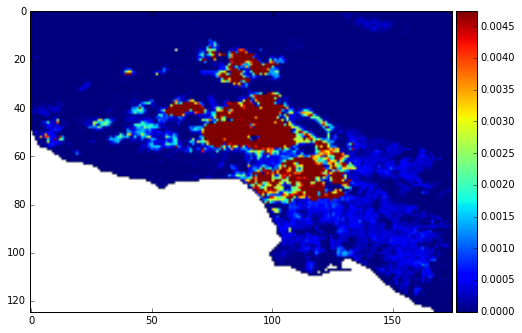

In [45]:
mmidata = expmodel.getShakeGrid().getLayer('mmi').getData()
popdata = expmodel.getEconPopulationGrid().getData()
isodata = expmodel.getCountryGrid().getData()
ecogrid = empeco.getLossGrid(mmidata,popdata,isodata)
f = plt.figure(figsize=(8,8))
dmin = np.nanmin(fatgrid)
dmax = np.nanmax(fatgrid)
dmean = np.nanmean(fatgrid)
dstd = np.nanstd(fatgrid)
#Here we're zooming in on the affected regions...
plt.imshow(fatgrid[125:250,125:300],vmin=dmin,vmax=dmean+(3*dstd));
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax);

Divide that economic loss grid by cities in LA County.

In [46]:
shapefile = os.path.join(sampledir,'City_BoundariesWGS84','City_Boundaries.shp')
popdict = expmodel.getPopulationGrid().getGeoDict()
shapes = []
f = fiona.open(shapefile,'r')
for row in f:
    shapes.append(row)
f.close()
ecoshapes,toteco = empeco.getLossByShapes(mmidata,popdata,isodata,shapes,popdict)
ecoshapes = sorted(ecoshapes,key=lambda shape:shape['properties']['dollars_lost'],reverse=True)
for shape in ecoshapes:
    if shape['properties']['dollars_lost'] > 0:
        cname = shape['properties']['CITY_NAME']
        dollars = shape['properties']['dollars_lost']
        print('%s: $%s dollars lost' % (cname,format(dollars,",d")))

Los Angeles: $17,323,352,577 dollars lost
Santa Clarita: $2,470,565,620 dollars lost
Unincorporated: $736,178,253 dollars lost
Burbank: $266,671,627 dollars lost
San Fernando: $245,654,998 dollars lost
Santa Monica: $185,402,549 dollars lost
Beverly Hills: $127,019,674 dollars lost
Calabasas: $69,710,713 dollars lost
Glendale: $51,322,351 dollars lost
Unincorporated: $21,507,941 dollars lost
Hidden Hills: $20,283,439 dollars lost
Unincorporated: $17,953,738 dollars lost
Unincorporated: $15,482,046 dollars lost
Agoura Hills: $15,028,615 dollars lost
Unincorporated: $14,698,190 dollars lost
Huntington Park: $13,161,613 dollars lost
Inglewood: $12,463,119 dollars lost
Culver City: $11,861,169 dollars lost
West Hollywood: $10,763,115 dollars lost
Bell: $8,567,085 dollars lost
Unincorporated: $7,501,274 dollars lost
Unincorporated: $6,611,490 dollars lost
Maywood: $4,849,242 dollars lost
Alhambra: $3,823,590 dollars lost
Pasadena: $3,804,850 dollars lost
El Segundo: $3,756,230 dollars lost


Compare Northridge losses to losses in other countries using the same economic exposure.

In [47]:
for name in names:
    fmodel = empeco.getModel(name)
    exp_pop = expdict['XF'][4:9]
    exp_pop[-1] += expdict['XF'][-1] #MMI 10 is folded into MMI 9 for loss modeling
    dollars = fmodel.getLosses(exp_pop,np.arange(5,10))
    dstr = format(int(dollars),",d")
    print('%s dollars lost from Northridge exposure: $%s' % (name,dstr))

JP dollars lost from Northridge exposure: $3,905,107,358
XF dollars lost from Northridge exposure: $23,172,277,187
IR dollars lost from Northridge exposure: $29,635,000,165
AF dollars lost from Northridge exposure: $79,939,946,597
CN dollars lost from Northridge exposure: $755,301,091,782
